In [3]:
# use svm with penalty (encourage smoothness)
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from plot_ult import *
import copy

import configparser
config = configparser.ConfigParser()
config.read_file(open('privateconfig'))
datafolder=config['Datafolder']['data']
datapath=Path(datafolder)


def hinge_loss(outputs, labels, model,reg=0.5, alpha=0.01):
    """
    折页损失计算
    :param outputs: 大小为(N, num_classes)
    :param labels: 大小为(N)
    :return: 损失值
    """
    num_labels = len(labels)
    corrects = outputs[range(num_labels), labels].unsqueeze(0).T

    # 最大间隔
    margin = 1.0
    margins = outputs - corrects + margin
    loss = torch.sum(torch.max(margins, 1)[0]) / len(labels)

    # # 正则化强度
    loss += alpha * torch.sum(model.weight ** 2)
    # weights smooth
    loss+=reg*torch.sum(torch.abs(torch.diff(torch.diff(model.weight, axis=0))))
    # loss-=torch.abs(model.weight[0,model.weight.shape[1]//2]-model.weight[0,model.weight.shape[1]//2-1]) # adjust for disjoint where v and w concat

    return loss


def train_model(data_loaders, model, criterion, optimizer, lr_scheduler, num_epochs=25, device=None):
    since = time.time()

    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                # print(inputs.shape)
                # print(labels.shape)
                # inputs = inputs.reshape(-1)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # print(outputs.shape)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels, model)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                lr_scheduler.step()

            epoch_loss = running_loss / data_sizes[phase]
            epoch_acc = running_corrects.double() / data_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_weights)
    return model


class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, x, y):
        'Initialization'
        self.labels = y
        self.list_IDs = x

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        x = self.list_IDs[index]
        y = self.labels[index]
        return x, y


def load_data(X, Y):

    data_loaders = {}
    data_sizes = {}
    totaln=len(Y)
    inds=torch.randperm(totaln)[:totaln//5]
   
    for name in ['train', 'val']:
        if name=='val':
            data_set=Dataset(X, Y)
        else:
            mask=torch.ones_like(Y)
            mask[inds]=0
            data_set=Dataset(X[mask], Y[mask])
        data_set=Dataset(X, Y)
        data_loader = DataLoader(data_set, shuffle=True, batch_size=128, num_workers=8)
        data_loaders[name] = data_loader
        data_sizes[name] = len(data_set)
        
    return data_loaders, data_sizes


def pad_to_dense(M, maxlen=0, padfirst=False):
    """Appends the minimal required amount of zeroes at the end of each 
     array in the jagged array `M`, such that `M` looses its jagedness."""
    if maxlen==0:
        maxlen = max(len(r) for r in M)
    Z = np.zeros((len(M), maxlen))
    if padfirst:
        for enu, row in enumerate(M):
            Z[enu, maxlen-min(maxlen, len(row)):] += row[:min(maxlen, len(row))]

    else:
        for enu, row in enumerate(M):
            Z[enu, :min(maxlen, len(row))] += row[:min(maxlen, len(row))]
    return Z


In [2]:

    # load data ----------------------------
    asd_data_set={}
    numhsub,numasub=25,14
    fulltrainfolder='persub1cont'
    parttrainfolder='persub3of5dp'
    for invtag in ['h','a']:
        for isub in range(numhsub):
            thesub="{}sub{}".format(invtag,str(isub))
            evalname=Path(datapath/"human/{}/evaltrain_inv{}sub{}".format(parttrainfolder,invtag,str(isub)))
            fullinverseres=Path(datapath/"human/{}".format(fulltrainfolder))/"inv{}sub{}".format(invtag,str(isub))
            partinverseres=Path(datapath/"human/{}".format(parttrainfolder))/"inv{}sub{}".format(invtag,str(isub))
            # load inv res
            if fullinverseres.is_file():
                asd_data_set['res'+thesub]=process_inv(fullinverseres, usingbest=True, removegr=False)
            # load data
            if Path(datapath/'human/{}'.format(thesub)).is_file():
                with open(datapath/'human/{}'.format(thesub), 'rb') as f:
                    states, actions, tasks = pickle.load(f)
                print(len(states))
                asd_data_set['data'+thesub]=states, actions, tasks
            
    alltag=[]
    allsamples_=[]
    maxlen=0
    cumsum=[0]
    running=0
    for invtag in ['h','a']:
        astartind=running
        for isub in range(numhsub):
            thesub="{}sub{}".format(invtag,str(isub))
            if 'data'+thesub in asd_data_set:
                _,actions,tasks=asd_data_set['data'+thesub]
                curmax=max([len(a) for a in actions])
                maxlen=max(maxlen, curmax)
                running+=len(actions)
                cumsum.append(running)
    for invtag in ['h','a']:
        for isub in range(numhsub):
            thesub="{}sub{}".format(invtag,str(isub))
            if 'data'+thesub in asd_data_set:
                _,actions,tasks=asd_data_set['data'+thesub]
                # paddedv=pad_to_dense([np.array(a[:,0]) for a in actions],maxlen=maxlen)
                # paddedw=pad_to_dense([np.array(a[:,1])*sign for sign, a in zip(np.array(tasks[:,1]>0, dtype=int)*-1, actions)],maxlen=maxlen)
                # allsamples_.append(np.hstack([tasks,paddedv,paddedw])) # baseline
                # allsamples_.append(np.hstack([paddedv,paddedw])) # remove the task, similar res
                # allsamples_.append(np.hstack([(paddedv.T/tasks[:,0]).T,(paddedw.T/np.abs(tasks[:,1])).T])) # devide the target distance and angle

                warpv=np.array([resample(np.array(a[:,0]), maxlen) for a in actions])
                warpw=np.array([resample(np.array(a[:,1])*sign, maxlen) for sign, a in zip(np.array(tasks[:,1]>0, dtype=int)*-1, actions)])
                allsamples_.append(np.hstack([warpv, warpw])) # resample instead of padding (time warpping)
                # allsamples_.append(np.hstack([tasks, warpv, warpw])) # resample instead of padding (time warpping) and target
                # allsamples_.append(np.hstack([(warpv.T/tasks[:,0]).T, (warpw.T/np.abs(tasks[:,1])).T])) # resample instead of padding (time warpping) and divde by target

                if invtag=='a':
                    alltag+=[1]*len(actions)
                else:
                    alltag+=[0]*len(actions)

    allsamples=np.vstack(allsamples_)
    alltag=np.array(alltag).astype('int') # asd is 1


    # my svm, encourage smoother weights -----------------------
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    X, Y=torch.tensor(allsamples).float(),torch.tensor(alltag)
    # X.shape
    model = nn.Linear(X.shape[1], 2).to(device)
    # criterion = nn.CrossEntropyLoss()
    criterion = hinge_loss
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
    lr_schduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    data_loaders, data_sizes = load_data(X, Y)
    train_model(data_loaders, model, criterion, optimizer, lr_schduler, num_epochs=11, device=device)
    # plt.plot(model.weight.clone().detach()[0])
    # plt.plot(model.weight.clone().detach()[1])
    # plt.show()
    diffs=(model.weight.clone().detach()[1]-model.weight.clone().detach()[0])[2:]
    # plt.plot(diffs[:len(diffs)//2][:50])
    # plt.plot(diffs[len(diffs)//2:][:50])


    # projected on most seperable axis svm ----------------------

    w=(model.weight.clone().detach()[1]-model.weight.clone().detach()[0])
    ticks=X[:,:]@(w)
    fig = plt.figure()
    ax  = fig.add_subplot(111)
    ax.hist(ticks[Y==0],density=True,color='b',bins=99,label='health control',alpha=0.6)
    ax.hist(ticks[Y==1],density=True,color='r',bins=99,label='ASD',alpha=0.6)
    ax.set_xlabel('param value')
    ax.set_ylabel('probability')
    # ax.set_xlim(-1,1)
    quickspine(ax)
    # quicksave('asd behavior trajectory svm project smooth')


    # per subject 
    # per subject curve
    print('there are some diff. asd seems to be a bi modal distribution. plot individuals to check')
    from numpy import linspace
    from scipy import stats 
    fig = plt.figure(figsize=(6,3))
    ax1  = fig.add_subplot(121)
    ax2  = fig.add_subplot(122, sharey=ax1,sharex=ax1)
    for i, (s,e) in enumerate(zip(cumsum[:-1], cumsum[1:])):
        ticks=X[s:e,:]@(w)
        if s>=astartind: # ASD
            cm_subsection = linspace(0,1, 25) 
            colors = [ cm.gist_heat(x) for x in cm_subsection ]
            # ax2.hist(ticks,density=True,bins=33,alpha=0.6)
            density = stats.gaussian_kde(ticks)
            n, x = np.histogram(ticks, bins=33,density=True)
            ax2.plot(x, density(x),linewidth=1, color=colors[i-numhsub])
        else: # NT
            cm_subsection = linspace(0, 0.8, 25) 
            colors = [ cm.winter(x) for x in cm_subsection ]
            # ax1.hist(ticks,density=True,bins=33,alpha=0.6)
            density = stats.gaussian_kde(ticks)
            n, x = np.histogram(ticks, bins=33,density=True)
            ax1.plot(x, density(x), linewidth=1, color=colors[i])

        ax1.set_xlabel('param value')
        ax1.set_ylabel('probability density')
        quickspine(ax1)
        ax2.set_xlabel('param value')
        quickspine(ax2)
    # quicksave('asd behavior trajectory svm smooth individual')
    print('the other peak suggest asd behavior. still they are mixed')



    # weights of the svm ----------------------------
    sec=20
    with initiate_plot(5,2,300) as f:

        ax=f.add_subplot(121)
        ax.plot(np.linspace(2,sec,(sec-3)*10),(diffs[:len(diffs)//2][20:(sec-1)*10]), color='k')
        quickspine(ax)
        ax.set_xlabel('warpped time')
        ax.set_ylabel('v control coef')
        ax.set_xticks(ax.get_xlim())
        ax.set_xticklabels(['start' ,'end'])

        ax=f.add_subplot(122, sharex=ax, sharey=ax)
        ax.plot(np.linspace(2,sec,(sec-3)*10),(diffs[len(diffs)//2:][20:(sec-1)*10]), color='k')
        quickspine(ax)
        ax.set_xlabel('warpped time')
        ax.set_ylabel('w control coef')
        plt.tight_layout()
        # quicksave('v and w coef of trajectory svm smooth')



/Users/yc/Documents/lab_data/human/persub1cont/invhsub0
using ind:  85 final logll :  10.98047685623169
148
/Users/yc/Documents/lab_data/human/persub1cont/invhsub1
using ind:  47 final logll :  9.29283959524972
147
/Users/yc/Documents/lab_data/human/persub1cont/invhsub2
using ind:  83 final logll :  4.200698069163731
146
/Users/yc/Documents/lab_data/human/persub1cont/invhsub3
using ind:  48 final logll :  10.158493995666504
145
/Users/yc/Documents/lab_data/human/persub1cont/invhsub4
using ind:  53 final logll :  7.978296484266009
147
/Users/yc/Documents/lab_data/human/persub1cont/invhsub5
using ind:  57 final logll :  4.561488900865827
146
/Users/yc/Documents/lab_data/human/persub1cont/invhsub6
using ind:  58 final logll :  7.864906413214547
148
/Users/yc/Documents/lab_data/human/persub1cont/invhsub7
using ind:  56 final logll :  7.848775114331927
145
/Users/yc/Documents/lab_data/human/persub1cont/invhsub8
using ind:  57 final logll :  7.107513700212751
145
/Users/yc/Documents/lab_data

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/yc/miniconda3/envs/lab/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/yc/miniconda3/envs/lab/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'Dataset' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/yc/miniconda3/envs/lab/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/yc/miniconda3/envs/lab/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError

RuntimeError: DataLoader worker (pid(s) 68410) exited unexpectedly

In [ ]:

    # 0223, pad first, pad last, all in one

    # load data ----------------------------
    asd_data_set={}
    numhsub,numasub=25,14
    fulltrainfolder='persub1cont'
    parttrainfolder='persub3of5dp'
    for invtag in ['h','a']:
        for isub in range(numhsub):
            thesub="{}sub{}".format(invtag,str(isub))
            evalname=Path(datapath/"human/{}/evaltrain_inv{}sub{}".format(parttrainfolder,invtag,str(isub)))
            fullinverseres=Path(datapath/"human/{}".format(fulltrainfolder))/"inv{}sub{}".format(invtag,str(isub))
            partinverseres=Path(datapath/"human/{}".format(parttrainfolder))/"inv{}sub{}".format(invtag,str(isub))
            # load inv res
            if fullinverseres.is_file():
                asd_data_set['res'+thesub]=process_inv(fullinverseres, usingbest=True, removegr=False)
            # load data
            if Path(datapath/'human/{}'.format(thesub)).is_file():
                with open(datapath/'human/{}'.format(thesub), 'rb') as f:
                    states, actions, tasks = pickle.load(f)
                print(len(states))
                asd_data_set['data'+thesub]=states, actions, tasks
            
    alltag=[]
    allsamples_=[]
    maxlen=0
    cumsum=[0]
    running=0
    for invtag in ['h','a']:
        astartind=running
        for isub in range(numhsub):
            thesub="{}sub{}".format(invtag,str(isub))
            if 'data'+thesub in asd_data_set:
                _,actions,tasks=asd_data_set['data'+thesub]
                curmax=max([len(a) for a in actions])
                maxlen=max(maxlen, curmax)
                running+=len(actions)
                cumsum.append(running)
    for invtag in ['h','a']:
        for isub in range(numhsub):
            thesub="{}sub{}".format(invtag,str(isub))
            if 'data'+thesub in asd_data_set:
                _,actions,tasks=asd_data_set['data'+thesub]
                paddedv=pad_to_dense([np.array(a[:,0]) for a in actions],maxlen=maxlen)
                paddedw=pad_to_dense([np.array(a[:,1])*sign for sign, a in zip(np.array(tasks[:,1]>0, dtype=int)*-1, actions)],maxlen=maxlen)
                firstpaddedv=pad_to_dense([np.array(a[:,0]) for a in actions], maxlen=maxlen, padfirst=True)
                firstpaddedw=pad_to_dense([np.array(a[:,1])*sign for sign, a in zip(np.array(tasks[:,1]>0, dtype=int)*-1, actions)], maxlen=maxlen,padfirst=True)                # allsamples_.append(np.hstack([tasks,paddedv,paddedw])) # baseline
                allsamples_.append(np.hstack([paddedv,firstpaddedv,paddedw,firstpaddedw])) # remove the task, similar res
                # allsamples_.append(np.hstack([(paddedv.T/tasks[:,0]).T,(paddedw.T/np.abs(tasks[:,1])).T])) # devide the target distance and angle

                # warpv=np.array([resample(np.array(a[:,0]), maxlen) for a in actions])
                # warpw=np.array([resample(np.array(a[:,1])*sign, maxlen) for sign, a in zip(np.array(tasks[:,1]>0, dtype=int)*-1, actions)])
                # allsamples_.append(np.hstack([warpv, warpw])) # resample instead of padding (time warpping)
                # allsamples_.append(np.hstack([tasks, warpv, warpw])) # resample instead of padding (time warpping) and target
                # allsamples_.append(np.hstack([(warpv.T/tasks[:,0]).T, (warpw.T/np.abs(tasks[:,1])).T])) # resample instead of padding (time warpping) and divde by target

                if invtag=='a':
                    alltag+=[1]*len(actions)
                else:
                    alltag+=[0]*len(actions)

    allsamples=np.vstack(allsamples_)
    alltag=np.array(alltag).astype('int') # asd is 1


    # my svm, encourage smoother weights -----------------------
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    X, Y=torch.tensor(allsamples).float(),torch.tensor(alltag)
    # X.shape
    model = nn.Linear(X.shape[1], 2).to(device)
    # criterion = nn.CrossEntropyLoss()
    criterion = hinge_loss
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
    lr_schduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    data_loaders, data_sizes = load_data(X, Y)
    train_model(data_loaders, model, criterion, optimizer, lr_schduler, num_epochs=11, device=device)
    # plt.plot(model.weight.clone().detach()[0])
    # plt.plot(model.weight.clone().detach()[1])
    # plt.show()
    diffs=(model.weight.clone().detach()[1]-model.weight.clone().detach()[0])[2:]
    # plt.plot(diffs[:len(diffs)//2][:50])
    # plt.plot(diffs[len(diffs)//2:][:50])


    # projected on most seperable axis svm ----------------------
    w=(model.weight.clone().detach()[1]-model.weight.clone().detach()[0])
    ticks=X[:,:]@(w)
    fig = plt.figure()
    ax  = fig.add_subplot(111)
    ax.hist(ticks[Y==0],density=True,color='b',bins=99,label='health control',alpha=0.6)
    ax.hist(ticks[Y==1],density=True,color='r',bins=99,label='ASD',alpha=0.6)
    ax.set_xlabel('param value')
    ax.set_ylabel('probability')
    # ax.set_xlim(-1,1)
    quickspine(ax)
    # quicksave('asd behavior trajectory svm project smooth')



    # per subject curve
    print('there are some diff. asd seems to be a bi modal distribution. plot individuals to check')
    from numpy import linspace
    from scipy import stats 
    fig = plt.figure(figsize=(6,3))
    ax1  = fig.add_subplot(121)
    ax2  = fig.add_subplot(122, sharey=ax1,sharex=ax1)
    for i, (s,e) in enumerate(zip(cumsum[:-1], cumsum[1:])):
        ticks=X[s:e,:]@(w)
        if s>=astartind: # ASD
            cm_subsection = linspace(0, 1, 25) 
            colors = [ cm.gist_heat(x) for x in cm_subsection ]
            # ax2.hist(ticks,density=True,bins=33,alpha=0.6)
            density = stats.gaussian_kde(ticks)
            n, x = np.histogram(ticks, bins=33,density=True)
            ax2.plot(x, density(x),linewidth=1, color=colors[i-numhsub])
        else: # NT
            cm_subsection = linspace(0, 0.8, 25) 
            colors = [ cm.winter(x) for x in cm_subsection ]
            # ax1.hist(ticks,density=True,bins=33,alpha=0.6)
            density = stats.gaussian_kde(ticks)
            n, x = np.histogram(ticks, bins=33,density=True)
            ax1.plot(x, density(x), linewidth=1, color=colors[i])

        ax1.set_xlabel('param value')
        ax1.set_ylabel('probability density')
        quickspine(ax1)
        ax2.set_xlabel('param value')
        quickspine(ax2)
    # quicksave('asd behavior trajectory svm smooth individual')
    print('the other peak suggest asd behavior. still they are mixed')



    # weights of the svm ----------------------------
    maxlen=len(diffs)//4
    with initiate_plot(8,2,300) as f:
        ax=f.add_subplot(141)
        ax.plot(np.linspace(0,maxlen/10,maxlen),diffs[:maxlen], color='k')
        quickspine(ax)
        ax.set_xlabel('zero pad end')
        ax.set_ylabel('v control coef')
        ax.set_xticks(ax.get_xlim())
        ax.set_xticklabels(['start' ,'end'])

        ax=f.add_subplot(142, sharex=ax)
        ax.plot(np.linspace(0,maxlen/10,maxlen),diffs[maxlen:2*maxlen], color='k')
        quickspine(ax)
        ax.set_xlabel('zero pad front')
        ax.set_ylabel('v control coef')

        ax=f.add_subplot(143, sharex=ax)
        ax.plot(np.linspace(0,maxlen/10,maxlen),diffs[2*maxlen:3*maxlen], color='k')
        quickspine(ax)
        ax.set_xlabel('zero pad end')
        ax.set_ylabel('w control coef')
        
        ax=f.add_subplot(144, sharex=ax)
        ax.plot(np.linspace(0,maxlen/10,maxlen),diffs[3*maxlen:4*maxlen], color='k')
        quickspine(ax)
        ax.set_xlabel('zero pad front')
        ax.set_ylabel('w control coef')

        plt.tight_layout()
        # quicksave('v and w coef of trajectory svm smooth')







/Users/yc/Documents/lab_data/human/persub1cont/invhsub0
using ind:  85 final logll :  10.98047685623169
148
/Users/yc/Documents/lab_data/human/persub1cont/invhsub1
using ind:  47 final logll :  9.29283959524972
147
/Users/yc/Documents/lab_data/human/persub1cont/invhsub2
using ind:  83 final logll :  4.200698069163731
146
/Users/yc/Documents/lab_data/human/persub1cont/invhsub3
using ind:  48 final logll :  10.158493995666504
145
/Users/yc/Documents/lab_data/human/persub1cont/invhsub4
using ind:  53 final logll :  7.978296484266009
147
/Users/yc/Documents/lab_data/human/persub1cont/invhsub5
using ind:  57 final logll :  4.561488900865827
146
/Users/yc/Documents/lab_data/human/persub1cont/invhsub6
using ind:  58 final logll :  7.864906413214547
148
/Users/yc/Documents/lab_data/human/persub1cont/invhsub7
using ind:  56 final logll :  7.848775114331927
145
/Users/yc/Documents/lab_data/human/persub1cont/invhsub8
using ind:  57 final logll :  7.107513700212751
145
/Users/yc/Documents/lab_data

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/yc/miniconda3/envs/lab/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/yc/miniconda3/envs/lab/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'Dataset' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/yc/miniconda3/envs/lab/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/yc/miniconda3/envs/lab/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError

RuntimeError: DataLoader worker (pid(s) 67605) exited unexpectedly

/Users/yc/Documents/lab_data/human/persub1cont/invhsub0
using ind:  85 final logll :  10.98047685623169
148
/Users/yc/Documents/lab_data/human/persub1cont/invhsub1
using ind:  47 final logll :  9.29283959524972
147
/Users/yc/Documents/lab_data/human/persub1cont/invhsub2
using ind:  83 final logll :  4.200698069163731
146
/Users/yc/Documents/lab_data/human/persub1cont/invhsub3
using ind:  48 final logll :  10.158493995666504
145
/Users/yc/Documents/lab_data/human/persub1cont/invhsub4
using ind:  53 final logll :  7.978296484266009
147
/Users/yc/Documents/lab_data/human/persub1cont/invhsub5
using ind:  57 final logll :  4.561488900865827
146
/Users/yc/Documents/lab_data/human/persub1cont/invhsub6
using ind:  58 final logll :  7.864906413214547
148
/Users/yc/Documents/lab_data/human/persub1cont/invhsub7
using ind:  56 final logll :  7.848775114331927
145
/Users/yc/Documents/lab_data/human/persub1cont/invhsub8
using ind:  57 final logll :  7.107513700212751
145
/Users/yc/Documents/lab_data

NameError: name 'maxlen' is not defined

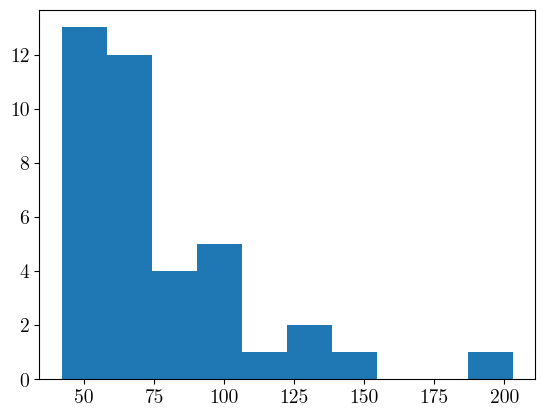

In [ ]:


    # baseline svm (no smoothing) -------------------------------
    from sklearn import svm
    asd_data_set={}
    numhsub,numasub=25,14
    fulltrainfolder='persub1cont'
    parttrainfolder='persub3of5dp'
    for invtag in ['h','a']:
        for isub in range(numhsub):
            thesub="{}sub{}".format(invtag,str(isub))
            evalname=Path(datapath/"human/{}/evaltrain_inv{}sub{}".format(parttrainfolder,invtag,str(isub)))
            fullinverseres=Path(datapath/"human/{}".format(fulltrainfolder))/"inv{}sub{}".format(invtag,str(isub))
            partinverseres=Path(datapath/"human/{}".format(parttrainfolder))/"inv{}sub{}".format(invtag,str(isub))
            # load inv res
            if fullinverseres.is_file():
                asd_data_set['res'+thesub]=process_inv(fullinverseres, usingbest=True, removegr=False)
            # load data
            if Path(datapath/'human/{}'.format(thesub)).is_file():
                with open(datapath/'human/{}'.format(thesub), 'rb') as f:
                    states, actions, tasks = pickle.load(f)
                print(len(states))
                asd_data_set['data'+thesub]=states, actions, tasks
            

    lens=[]
    cumsum=[0]
    running=0
    for invtag in ['h','a']:
        astartind=running
        for isub in range(numhsub):
            thesub="{}sub{}".format(invtag,str(isub))
            if 'data'+thesub in asd_data_set:
                _,actions,tasks=asd_data_set['data'+thesub]
                curmax=max([len(a) for a in actions])
                lens.append(curmax)
                running+=len(actions)
                cumsum.append(running)

    plt.hist(lens)
    
    minlen=60
    maxlne=100
    alltag=[]
    allsamples_=[]
    for invtag in ['h','a']:
        for isub in range(numhsub):
            thesub="{}sub{}".format(invtag,str(isub))
            if 'data'+thesub in asd_data_set:
                _,actions,tasks=asd_data_set['data'+thesub]
                
                for a, sign in zip(actions, np.array(tasks[:,1]>0, dtype=int)*-1):
                    if minlen<len(a)<maxlen:
                        paddedv=pad_to_dense([np.array(a[:,0])],maxlen=maxlen)
                        paddedw=pad_to_dense([np.array(a[:,1])*sign],maxlen=maxlen)
                        allsamples_.append(np.hstack([paddedv,paddedw])) 

                        if invtag=='a':
                            alltag+=[1]
                        else:
                            alltag+=[0]

    allsamples=np.vstack(allsamples_)
    alltag=np.array(alltag).astype('int') # asd is 1


    X, Y=allsamples,alltag
    X = X[np.logical_or(Y==0,Y==1)][:,:]
    Y = Y[np.logical_or(Y==0,Y==1)]
    baselinemodel = svm.SVC(kernel='linear')
    clf = baselinemodel.fit(X, Y)
    # f_importances(np.abs(clf.coef_[0][2:]),list(range(9)))
    # quicksave('svm trajectory weights')

    with initiate_plot(5,2,300) as f:
        vwcoef=(clf.coef_[0][2:])
        maxcoef=max(vwcoef)
        normvwcoef=vwcoef/maxcoef
        ax=f.add_subplot(121)
        ax.plot(np.linspace(0,len(normvwcoef[:maxlen])/10,len(normvwcoef[:maxlen]) ),(normvwcoef[:maxlen]), color='k')
        quickspine(ax)
        ax.set_xlabel('time s')
        ax.set_ylabel('v control coef')
        # ax.set_ylim(0,1)
        ax.set_xlim(-1,15)
        ax=f.add_subplot(122, sharey=ax)
        ax.plot(np.linspace(0,len(normvwcoef[maxlen:])/10,len(normvwcoef[maxlen:])),(normvwcoef[maxlen:]), color='k')
        quickspine(ax)
        ax.set_xlabel('time s')
        ax.set_ylabel('w control coef')
        # ax.set_ylim(0,1)
        ax.set_xlim(-1,15)
        # quicksave('v and w coef of trajectory svm')

    print('''
    project the individual trajectory on to the normal vector.
    ''')
    # svm and curve together
    w=clf.coef_[0]
    ticks=X[:,:].dot(w)

    ticks=X@w.reshape(-1,1)
    fig = plt.figure()
    ax  = fig.add_subplot(111)
    ax.hist(ticks[Y==0],density=True,color='b',bins=99,label='health control',alpha=0.6)
    ax.hist(ticks[Y==1],density=True,color='r',bins=99,label='ASD',alpha=0.6)
    ax.set_xlabel('param value')
    ax.set_ylabel('probability')
    quickspine(ax)

